In [146]:
# Data manipulation libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Factor analysis and PCA libraries
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import minmax_scale

# Scaler
from sklearn.preprocessing import StandardScaler
import warnings

# Settings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (16, 9)

In [147]:
data = pd.read_csv('store_unified_summary.csv', encoding='utf-8-sig')

# 확인
print(data.shape)
print(data.head())

(975, 67)
   store_id  owner_id business_registration_no  industry_code   open_date  \
0       101      1101             101-74-60399          56112  2024-11-04   
1       101      1101             101-80-14374          56112  2024-11-04   
2       101      1101             101-90-34754          56112  2024-11-04   
3       101      1101             101-04-50959          56112  2024-11-04   
4       101      1101             101-31-21926          56112  2024-11-04   

  summary_year_month  total_sales_amount  weekday_sales_amount  \
0            2024-11          2800000.00            1540000.00   
1            2024-12          3186680.00            1752674.00   
2            2025-01          3577048.30            1967376.57   
3            2025-02          4053153.43            2229234.39   
4            2025-03          4600329.14            2530181.03   

   weekend_sales_amount  lunch_sales_ratio  dinner_sales_ratio  \
0            1260000.00              31.82               26.93  

In [149]:
# 1. 제외할 컬럼 정의
exclude_cols = [
    "store_id", "owner_id",
    "open_date", "summary_year_month", "created_dttm", "updated_dttm", "last_updated_dttm"
]

# 2. 연속형 숫자형 컬럼만 선택
numeric_cols = data.select_dtypes(include=["int64", "float64"]).columns.tolist()

# 3. 제외 컬럼 제거 후 잡음 대상 컬럼만 추출
target_cols = [col for col in numeric_cols if col not in exclude_cols]

# 4. 잡음 추가 함수 정의
def add_noise(series, noise_level=0.01):
    std = series.std()
    noise = np.random.normal(0, noise_level * std, size=series.shape)
    return series + noise

# 5. 잡음 추가 적용
data_noisy = data.copy()
data_noisy[target_cols] = data_noisy[target_cols].apply(lambda col: add_noise(col, noise_level=0.01))

In [150]:
data

,store_id,owner_id,business_registration_no,industry_code,open_date,summary_year_month,total_sales_amount,weekday_sales_amount,weekend_sales_amount,lunch_sales_ratio,dinner_sales_ratio,transaction_count,weekday_transaction_count,weekend_transaction_count,mom_growth_rate,yoy_growth_rate,sales_cv,avg_transaction_value,weekday_avg_transaction_value,weekend_avg_transaction_value,cash_payment_ratio,card_payment_ratio,revisit_customer_sales_ratio,new_customer_ratio,created_dttm,updated_dttm,last_updated_dttm,electricity_usage_kwh,electricity_bill_amount,gas_usage_m3,water_usage_ton,energy_eff_appliance_ratio,participate_energy_eff_support,participate_high_eff_equip_support,food_waste_kg_per_day,recycle_waste_kg_per_day,yellow_umbrella_member,yellow_umbrella_months,yellow_umbrella_amount,employment_insurance_employees,customer_review_avg_rating,customer_review_positive_ratio,hygiene_certified,origin_price_violation_count,operating_profit,cost_of_goods_sold,total_salary,operating_expenses,rent_expense,other_expenses,operating_profit_ratio,cogs_ratio,salary_ratio,rent_ratio,operating_expense_ratio,cash_payment_ratio_detail,card_payment_ratio_detail,other_payment_ratio,weighted_avg_cash_period,cashflow_cv,avg_account_balance,min_balance_maintenance_ratio,excessive_withdrawal_frequency,rent_payment_compliance_rate,utility_payment_compliance_rate,salary_payment_regularity,tax_payment_integrity
0,101,1101,101-74-60399,56112,2024-11-04,2024-11,2800000.00,1540000.00,1260000.00,31.82,26.93,172,94,78,1.19,NaN,0.1422,16198.0,15226.0,18141.0,15.6,84.4,40.07,53.70,2025-09-08 00:21:10,2025-09-08 00:21:18,2025-09-08 00:21:10,863.54,111394.78,503.16,9.31,35.73,0,0,6.53,5.24,0,0,0.0,0,3.90,50.51,0,0,400511.13,1357440.00,434000.00,2399488.87,314720.00,293328.87,14.30,48.48,15.50,11.24,85.70,53.27,44.55,2.18,1.22,0.3893,1733451.54,59.98,2.8,61.81,72.72,59.83,68.72
1,101,1101,101-80-14374,56112,2024-11-04,2024-12,3186680.00,1752674.00,1434006.00,24.58,26.45,190,104,86,13.81,NaN,0.1652,16758.0,15753.0,18769.0,19.4,80.6,50.74,69.79,2025-09-08 00:21:10,2025-09-08 00:21:18,2025-09-08 00:21:10,1124.53,130854.50,693.82,8.52,39.54,0,0,8.25,9.87,0,0,0.0,0,3.79,59.61,0,0,404509.21,1648150.90,548746.30,2782170.79,328228.04,257045.55,12.69,51.72,17.22,10.30,87.31,64.28,33.21,2.51,0.96,0.5050,2089948.05,42.61,2.0,77.86,46.09,54.71,72.81
2,101,1101,101-90-34754,56112,2024-11-04,2025-01,3577048.30,1967376.57,1609671.74,20.39,26.32,191,105,86,12.25,NaN,0.1490,18686.0,17565.0,20928.0,15.9,84.1,51.00,63.24,2025-09-08 00:21:10,2025-09-08 00:21:18,2025-09-08 00:21:10,1076.55,129244.78,740.47,8.18,60.68,0,0,6.87,6.02,0,0,0.0,0,3.86,57.41,0,0,553038.53,1723421.87,546215.28,3024009.77,393475.31,360897.31,15.46,48.18,15.27,11.00,84.54,63.36,32.64,4.00,1.02,0.5780,2210184.70,38.25,1.0,67.99,62.16,75.28,89.14
3,101,1101,101-04-50959,56112,2024-11-04,2025-02,4053153.43,2229234.39,1823919.04,26.34,33.74,196,107,89,13.31,NaN,0.1718,20665.0,19425.0,23145.0,18.5,81.5,49.79,60.10,2025-09-08 00:21:10,2025-09-08 00:21:18,2025-09-08 00:21:10,913.30,106184.46,627.34,8.09,37.72,0,0,5.62,6.30,0,0,0.0,0,3.25,51.33,0,0,598862.74,1978749.50,712544.37,3454290.69,366810.39,396186.43,14.78,48.82,17.58,9.05,85.22,56.24,40.69,3.07,1.17,1.3262,2875204.93,46.57,2.2,66.28,82.25,47.73,64.92
4,101,1101,101-31-21926,56112,2024-11-04,2025-03,4600329.14,2530181.03,2070148.11,22.07,25.49,200,110,90,13.50,NaN,0.1800,22938.0,21562.0,25691.0,21.9,78.1,52.98,69.91,2025-09-08 00:21:10,2025-09-08 00:21:18,2025-09-08 00:21:10,770.05,92266.94,505.50,9.16,40.55,0,0,7.93,8.35,0,0,0.0,0,3.64,55.99,0,0,749643.33,2176415.72,831279.48,3850685.81,453592.45,389398.16,16.30,47.31,18.07,9.86,83.70,62.88,34.11,3.01,1.00,0.9865,2336156.57,74.05,5.9,67.63,66.41,54.54,60.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [151]:
# 1. ID 컬럼 제거
data_noisy2 = data_noisy.drop(data_noisy.columns[[0, 1]], axis=1)

# 2. 숫자형 컬럼만 선택
numeric_cols = data_noisy2.select_dtypes(include=["int64", "float64"]).columns

# 3. exclude_cols 제거
target_cols = [col for col in numeric_cols if col not in exclude_cols]

# 4. 표준화 수행
scaler = StandardScaler()
standardized_X = pd.DataFrame(
    scaler.fit_transform(data_noisy[target_cols]),
    columns=target_cols
)

# 5. 원본 데이터에 반영
data_standardized = data_noisy.copy()
data_standardized[target_cols] = standardized_X

In [152]:
data_standardized.head()

,store_id,owner_id,business_registration_no,industry_code,open_date,summary_year_month,total_sales_amount,weekday_sales_amount,weekend_sales_amount,lunch_sales_ratio,dinner_sales_ratio,transaction_count,weekday_transaction_count,weekend_transaction_count,mom_growth_rate,yoy_growth_rate,sales_cv,avg_transaction_value,weekday_avg_transaction_value,weekend_avg_transaction_value,cash_payment_ratio,card_payment_ratio,revisit_customer_sales_ratio,new_customer_ratio,created_dttm,updated_dttm,last_updated_dttm,electricity_usage_kwh,electricity_bill_amount,gas_usage_m3,water_usage_ton,energy_eff_appliance_ratio,participate_energy_eff_support,participate_high_eff_equip_support,food_waste_kg_per_day,recycle_waste_kg_per_day,yellow_umbrella_member,yellow_umbrella_months,yellow_umbrella_amount,employment_insurance_employees,customer_review_avg_rating,customer_review_positive_ratio,hygiene_certified,origin_price_violation_count,operating_profit,cost_of_goods_sold,total_salary,operating_expenses,rent_expense,other_expenses,operating_profit_ratio,cogs_ratio,salary_ratio,rent_ratio,operating_expense_ratio,cash_payment_ratio_detail,card_payment_ratio_detail,other_payment_ratio,weighted_avg_cash_period,cashflow_cv,avg_account_balance,min_balance_maintenance_ratio,excessive_withdrawal_frequency,rent_payment_compliance_rate,utility_payment_compliance_rate,salary_payment_regularity,tax_payment_integrity
0,101,1101,101-74-60399,-0.513323,2024-11-04,2024-11,-0.603624,-0.601682,-0.547195,0.384487,-0.165665,-0.633342,-0.676177,-0.546727,0.220446,NaN,0.178707,-0.041853,-0.020867,-0.038963,-0.765802,0.772550,-1.398263,0.305920,2025-09-08 00:21:10,2025-09-08 00:21:18,2025-09-08 00:21:10,-1.200791,-1.122239,-0.406234,-1.447259,-1.467892,-0.553533,-0.460834,-0.806404,-0.927980,-0.790873,-0.469164,-0.649525,-0.461695,-0.093722,-0.706508,-0.251257,-0.278908,-0.583550,-0.575865,-0.609903,-0.602384,-0.588509,-0.570326,-0.706806,0.392943,-0.715675,0.950689,0.722584,-0.365371,0.445439,-1.368214,0.225472,-0.806205,-0.551570,-0.171285,0.210119,-0.958604,0.085997,-0.624769,-0.893377
1,101,1101,101-80-14374,-0.507871,2024-11-04,2024-12,-0.575607,-0.591347,-0.527879,-0.528641,-0.207572,-0.612021,-0.654977,-0.550521,3.448815,NaN,0.544081,0.064608,0.075472,0.064744,-0.390233,0.386137,-0.588834,1.509574,2025-09-08 00:21:10,2025-09-08 00:21:18,2025-09-08 00:21:10,-0.885529,-0.914417,0.104635,-1.539207,-1.181835,-0.554602,-0.462392,-0.495259,-0.154879,-0.779959,-0.489254,-0.665689,-0.461942,-0.330405,0.110196,-0.246640,-0.279050,-0.574312,-0.548321,-0.559475,-0.588131,-0.587878,-0.593184,-1.085978,1.639786,0.451201,0.127675,1.065180,1.175139,-1.120728,-0.796751,-1.239209,-0.350776,-0.532834,-1.042063,-0.146616,0.109410,-1.636808,-0.934202,-0.553927
2,101,1101,101-90-34754,-0.488605,2024-11-04,2025-01,-0.561001,-0.588492,-0.520089,-1.076381,-0.221254,-0.617365,-0.659276,-0.553070,3.046528,NaN,0.295819,0.326672,0.345942,0.335355,-0.733883,0.744000,-0.594072,1.004876,2025-09-08 00:21:10,2025-09-08 00:21:18,2025-09-08 00:21:10,-0.950006,-0.947497,0.229515,-1.567695,0.223257,-0.583703,-0.445001,-0.750775,-0.809765,-0.775966,-0.477711,-0.644938,-0.457771,-0.168599,-0.095759,-0.256178,-0.269886,-0.543866,-0.554009,-0.562831,-0.557122,-0.572467,-0.545258,-0.454817,0.283762,-0.877753,0.736690,0.454791,1.049587,-1.183511,1.780574,-0.898854,-0.089749,-0.530986,-1.269548,-0.609769,-0.552354,-0.578731,0.338337,0.894387
3,101,1101,101-04-50959,-0.497531,2024-11-04,2025-02,-0.565196,-0.563947,-0.499448,-0.307766,0.494874,-0.608957,-0.643336,-0.542228,3.325013,NaN,0.655447,0.638824,0.597741,0.621664,-0.479513,0.482149,-0.662841,0.793072,2025-09-08 00:21:10,2025-09-08 00:21:18,2025-09-08 00:21:10,-1.164003,-1.165125,-0.066579,-1.576694,-1.321162,-0.583909,-0.463603,-0.973571,-0.763385,-0.792268,-0.470783,-0.655264,-0.449728,-1.441424,-0.634648,-0.236642,-0.276714,-0.540865,-0.523668,-0.534236,-0.544559,-0.551945,-0.525513,-0.597006,0.518012,0.694100,-0.987809,0.615467,0.067059,-0.107079,0.

### 2. KMO / Bartlett 검정

In [154]:
# ===============================
# 1) 제외할 컬럼 정의 (id, 날짜, boolean)
# ===============================
exclude_cols = [
    "store_id", "owner_id",
    "open_date", "summary_year_month", "created_dttm", "updated_dttm", "last_updated_dttm"
]

# ===============================
# 2) 숫자형 컬럼만 선택 후 exclude_cols 제거
# ===============================
numeric_cols = data_standardized.select_dtypes(include=["int64", "float64"]).columns
validation_cols = [col for col in numeric_cols if col not in exclude_cols]
X_validation = data_standardized[validation_cols]

# ===============================
# 3) NaN / Inf 제거
# ===============================
X_validation = X_validation.replace([np.inf, -np.inf], np.nan).dropna()

# ===============================
# 4) 분산이 0에 가까운 컬럼 제거
# ===============================
selector = VarianceThreshold(threshold=1e-5)
X_validation_filtered = pd.DataFrame(
    selector.fit_transform(X_validation),
    columns=X_validation.columns[selector.get_support()]
)

# ===============================
# 5) 상관 높은 컬럼 제거 (선택적으로)
# ===============================
corr_matrix = X_validation_filtered.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.999)]
X_validation_filtered = X_validation_filtered.drop(columns=to_drop)
print("Data shape after preprocessing:", X_validation_filtered.shape)

# ===============================
# 6) Bartlett's Test
# ===============================
chi_square_value, p_value = calculate_bartlett_sphericity(X_validation_filtered)
print("Bartlett’s test: Chi-square =", chi_square_value, " p-value =", p_value)

# ===============================
# 7) KMO Test
# ===============================
kmo_all, kmo_model = calculate_kmo(X_validation_filtered)
print("KMO Model:", kmo_model)

Data shape after preprocessing: (392, 54)
Bartlett’s test: Chi-square = 43895.22567891362  p-value = 0.0
KMO Model: 0.8558256973058582


In [128]:
# ===============================
# 개별 변수 KMO 값 확인
# ===============================
kmo_all, kmo_model = calculate_kmo(X_validation_filtered)

# 개별 KMO 값과 컬럼명 매칭
kmo_df = pd.DataFrame({
    'column': X_validation_filtered.columns,
    'kmo_value': kmo_all
}).sort_values('kmo_value')

print("개별 변수 KMO 값:")
print(kmo_df)

# KMO 0.5 미만인 변수들 확인
low_kmo_cols = kmo_df[kmo_df['kmo_value'] < 0.5]['column'].tolist()
print(f"\nKMO 0.5 미만 변수 ({len(low_kmo_cols)}개):")
print(low_kmo_cols)

개별 변수 KMO 값:
                                column  kmo_value
16              operating_profit_ratio   0.377583
10                  new_customer_ratio   0.396805
36      employment_insurance_employees   0.404905
8        weekend_avg_transaction_value   0.417474
40        origin_price_violation_count   0.427439
25               electricity_usage_kwh   0.433726
30  participate_high_eff_equip_support   0.451017
0                        current_month   0.457013
2                 weekday_sales_amount   0.460396
38      customer_review_positive_ratio   0.466409
17           card_payment_ratio_detail   0.474828
18                         cashflow_cv   0.476643
29      participate_energy_eff_support   0.476707
24               tax_payment_integrity   0.477062
27                     water_usage_ton   0.477405
9                   card_payment_ratio   0.477522
1                   total_sales_amount   0.479596
21        rent_payment_compliance_rate   0.485136
6                      yoy_growth_rat

### 요인분석

In [155]:
X_validation_filtered.head()


,industry_code,total_sales_amount,weekday_sales_amount,weekend_sales_amount,lunch_sales_ratio,dinner_sales_ratio,transaction_count,weekday_transaction_count,weekend_transaction_count,mom_growth_rate,yoy_growth_rate,sales_cv,avg_transaction_value,cash_payment_ratio,revisit_customer_sales_ratio,new_customer_ratio,electricity_usage_kwh,electricity_bill_amount,gas_usage_m3,water_usage_ton,energy_eff_appliance_ratio,participate_energy_eff_support,participate_high_eff_equip_support,food_waste_kg_per_day,recycle_waste_kg_per_day,yellow_umbrella_member,yellow_umbrella_months,yellow_umbrella_amount,employment_insurance_employees,customer_review_avg_rating,customer_review_positive_ratio,hygiene_certified,origin_price_violation_count,operating_profit,cost_of_goods_sold,total_salary,rent_expense,other_expenses,operating_profit_ratio,cogs_ratio,salary_ratio,rent_ratio,cash_payment_ratio_detail,card_payment_ratio_detail,other_payment_ratio,weighted_avg_cash_period,cashflow_cv,avg_account_balance,min_balance_maintenance_ratio,excessive_withdrawal_frequency,rent_payment_compliance_rate,utility_payment_compliance_rate,salary_payment_regularity,tax_payment_integrity
0,-0.496877,-0.362019,-0.412347,-0.294772,0.526419,0.699524,-0.548453,-0.562606,-0.443819,1.126159,1.212718,-0.169439,1.209440,0.300755,-0.049180,0.784358,0.297903,0.469630,1.311963,0.099012,-0.530927,-0.573634,2.154940,0.138435,-0.000469,-0.763057,-0.464012,-0.648616,-0.461212,-0.680712,0.257172,-0.234828,1.402549,-0.410084,-0.379054,-0.328671,-0.403677,-0.303818,-0.454841,0.122088,1.108139,-0.818346,0.315531,-0.300730,0.008867,-0.332575,0.655942,-0.401983,-1.250229,2.572216,0.001396,-0.395483,-0.399871,-1.105678
1,-0.479281,-0.338222,-0.386052,-0.278399,-0.517362,0.821608,-0.493402,-0.552509,-0.439064,0.972182,1.215602,-0.150700,1.127934,0.594365,-0.317121,0.907344,0.148596,0.071092,1.415431,-0.704248,0.581950,-0.570960,-0.473930,-0.023404,0.114936,-0.773280,-0.492752,-0.642088,-0.451960,0.233316,0.389424,-0.251066,-0.284790,-0.406422,-0.321591,-0.389827,-0.330090,-0.257342,-0.594784,0.748982,-1.234554,0.574723,-0.506326,0.619947,-1.618917,0.376945,2.723413,-0.415596,-0.934504,-1.075333,0.682039,-0.841705,-1.671802,-1.265716
2,-0.489081,-0.329516,-0.379119,-0.255899,-0.721190,0.186573,-0.480770,-0.538140,-0.401837,1.137555,1.200357,0.225891,0.894310,-0.109045,-0.849772,1.392227,-0.728755,-0.698019,0.193731,-0.129453,-0.945515,-0.577592,2.167310,-0.311762,0.069757,-0.775542,-0.481357,-0.642504,-0.467668,0.141170,-0.145123,-0.246198,-0.283894,-0.334786,-0.320481,-0.391845,-0.311813,-0.278698,-0.058108,0.614289,-2.148154,0.588443,0.978537,-0.946060,0.080586,-0.956849,1.596875,-0.438248,-1.146114,-0.891274,-0.743191,-1.358920,0.099322,-1.129166
3,-0.489299,-0.327321,-0.363927,-0.220675,-0.533169,-0.009873,-0.498919,-0.548610,-0.432010,0.968766,1.215056,0.171255,1.116666,0.508518,-0.544957,0.250035,-0.683622,-0.714173,-0.647597,0.059221,-1.817921,-0.580417,-0.469323,-0.077090,0.046391,-0.793780,-0.483763,-0.646993,-0.445339,0.440603,0.265345,-0.254608,-0.266587,-0.338977,-0.310270,-0.310254,-0.340900,-0.301959,-0.056122,0.095467,0.318731,-0.643179,-0.212666,0.302343,-1.048424,0.139360,0.365479,-0.361407,-1.483189,-0.679285,-1.456505,0.017725,0.488007,-0.087530
4,-0.478952,-0.287768,-0.359107,-0.223809,-0.830279,-0.319339,-0.516611,-0.548449,-0.425407,1.356587,1.210727,0.621573,1.638356,-0.462880,-1.250593,0.906311,-0.951519,-0.839035,-0.645199,-0.283068,-0.877220,1.749468,-0.469111,0.140125,-0.151467,1.278199,-0.255958,1.034065,-0.459340,0.439152,0.824505,-0.250489,1.407077,-0.220135,-0.271455,-0.342969,-0.415762,-0.301030,0.849746,0.478491,-1.302819,-2.732777,-1.206175,1.091138,1.253384,1.271612,1.067526,-0.359300,-1.539778,0.812714,0.654336,-1.465673,0.689126,-0.269679


Eigenvalues: [1.85553503e+01 8.63506586e+00 5.71141560e+00 2.74830457e+00
 2.40867309e+00 1.60947933e+00 1.30581387e+00 1.23555356e+00
 1.05886026e+00 1.04081826e+00 1.00354609e+00 9.50996734e-01
 9.34896800e-01 8.38251229e-01 8.02631137e-01 7.86124823e-01
 7.76760416e-01 7.24331008e-01 6.96425333e-01 6.82519333e-01
 6.66134284e-01 6.47466366e-01 5.98397535e-01 5.54781627e-01
 5.25295924e-01 5.03978026e-01 4.39115641e-01 3.74849068e-01
 3.38262698e-01 3.01210947e-01 2.47970333e-01 2.01906007e-01
 1.78131874e-01 1.64669085e-01 1.55859427e-01 1.55640324e-01
 1.17362529e-01 1.06874917e-01 5.55752720e-02 3.95502447e-02
 3.49874534e-02 2.69012285e-02 2.01096335e-02 1.32993395e-02
 7.25289518e-03 6.98474572e-03 6.26456662e-03 3.19739604e-03
 1.01960183e-03 2.53063711e-04 1.14087163e-04 1.07705913e-04
 1.06828623e-04 9.85986207e-05 9.53492157e-05 9.22901885e-05
 9.08769371e-05 8.84731324e-05 8.60945860e-05]


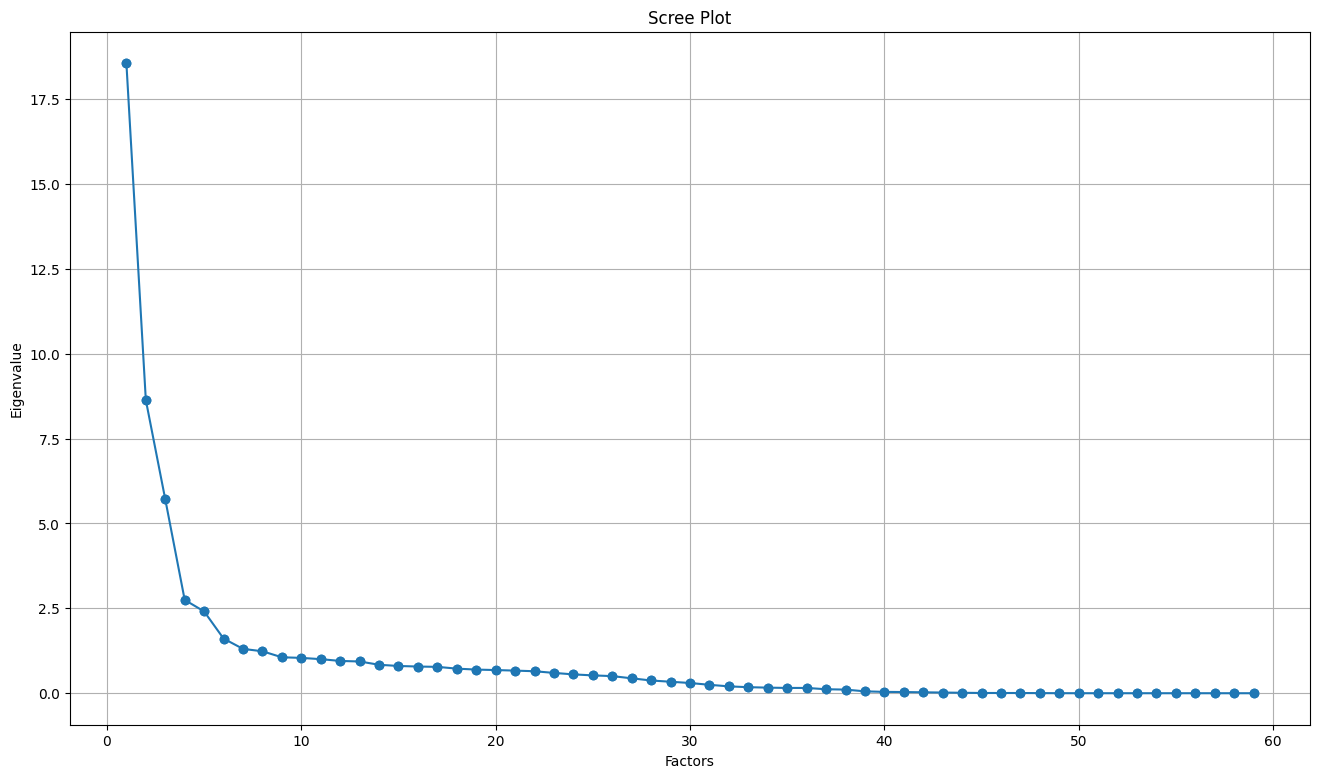

In [156]:
# 최대 요인 개수 = 변수 개수
fa = FactorAnalyzer(n_factors=standardized_X.shape[1], rotation=None)
fa.fit(standardized_X)

# 고유값 확인
ev, v = fa.get_eigenvalues()
print("Eigenvalues:", ev)

# Scree plot
plt.scatter(range(1, standardized_X.shape[1]+1), ev)
plt.plot(range(1, standardized_X.shape[1]+1), ev, marker='o')
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.show()

In [157]:
# 요인분석 수행 (예: n_factors=5)
fa = FactorAnalyzer(n_factors=5, rotation="varimax")
fa.fit(X_validation_filtered)

# 요인적재량
loadings = pd.DataFrame(fa.loadings_, index=X_validation_filtered.columns)

# 공통성
communalities = pd.DataFrame(fa.get_communalities(), index=X_validation_filtered.columns, columns=["Communality"])

In [158]:
# 각 행에서 절댓값이 최대인 값을 찾아 배경색을 노란색으로 지정하는 함수
def highlight_max_loading(row):
    is_max = row.abs() == row.abs().max()
    return ['background-color: #FFFACD' if v else '' for v in is_max]
    

# 요인 적재량 확인
result = loadings.style.apply(highlight_max_loading, axis=1)
result

,0,1,2,3,4
industry_code,0.117029,0.007522,-0.966014,0.067974,0.045529
total_sales_amount,0.973664,0.169800,0.048308,0.118318,0.058592
weekday_sales_amount,0.962293,0.175295,0.102454,0.089244,0.095199
weekend_sales_amount,0.968853,0.160079,-0.040936,0.166861,-0.002170
lunch_sales_ratio,-0.138375,-0.166092,0.760411,-0.255795,0.039488
dinner_sales_ratio,-0.052260,0.276796,0.848948,-0.059858,-0.006500
transaction_count,0.886087,0.123421,-0.291889,0.235582,0.000451
weekday_transaction_count,0.914500,0.130690,-0.232213,0.209451,0.045228
weekend_transaction_count,0.825178,0.109734,-0.363983,0.262881,-0.058200
mom_growth_rate,0.429581,0.509438,-0.093032,0.494811,-0.205332


In [159]:
# communalities 확인
def highlight_low_comm(row):
    is_under = row.abs() < 0.5
    return ['background-color: #FFFACD' if v else '' for v in is_under]

result2 = communalities.style.apply(highlight_low_comm, axis=1)
result2

,Communality
industry_code,0.953629
total_sales_amount,0.996619
weekday_sales_amount,0.984261
weekend_sales_amount,0.993825
lunch_sales_ratio,0.691949
dinner_sales_ratio,0.803685
transaction_count,0.941080
weekday_transaction_count,0.953228
weekend_transaction_count,0.897938
mom_growth_rate,0.739721


In [160]:
# 각 요인의 설명 분산 확인
ev, v, cv = fa.get_factor_variance()
ev_df = pd.DataFrame(
    {'SS Loadings': ev, 'Proportional Var': v, 'Cumulative Var': cv},
    index=[f'Factor{i+1}' for i in range(fa.n_factors)]
)

In [161]:
ev_df

,SS Loadings,Proportional Var,Cumulative Var
Factor1,12.032043,0.222816,0.222816
Factor2,9.780842,0.181127,0.403942
Factor3,4.566827,0.084571,0.488513
Factor4,4.329644,0.080179,0.568692
Factor5,2.481523,0.045954,0.614646


In [162]:
# ==============================
# 현재 사용 중인 데이터를 CSV로 내보내기
# ==============================

X_validation_filtered.to_csv('FA_input_data_20250909_2.csv', index=False, encoding='utf-8-sig')

### PCA 시각화

Explained variance ratio: [3.77459256e-01 1.34797701e-01 7.89079809e-02 5.32130553e-02
 4.03720510e-02 2.74604972e-02 1.93502583e-02 1.89342281e-02
 1.78229187e-02 1.62117694e-02 1.57493507e-02 1.44921155e-02
 1.40662678e-02 1.31285396e-02 1.26648151e-02 1.19361129e-02
 1.14346942e-02 1.10462461e-02 1.05836926e-02 9.89786375e-03
 9.48288044e-03 9.01780256e-03 8.58034124e-03 7.90902033e-03
 7.88720892e-03 7.32663581e-03 6.28545411e-03 5.07409424e-03
 4.44105569e-03 3.34216494e-03 3.17606550e-03 3.02465353e-03
 2.58677791e-03 2.25906096e-03 2.06708718e-03 1.73671856e-03
 1.51224507e-03 1.29399040e-03 8.24938012e-04 6.59720196e-04
 5.89085528e-04 3.77969691e-04 2.95856438e-04 2.25465724e-04
 1.59300687e-04 1.47302447e-04 1.03355329e-04 5.48986218e-05
 2.01107340e-05 3.68813959e-06 1.58260225e-06 1.45963353e-06
 1.31494449e-06 1.28028682e-06]
Components (Loadings):
     industry_code  total_sales_amount  weekday_sales_amount  \
0        0.032795            0.253526              0.249673   

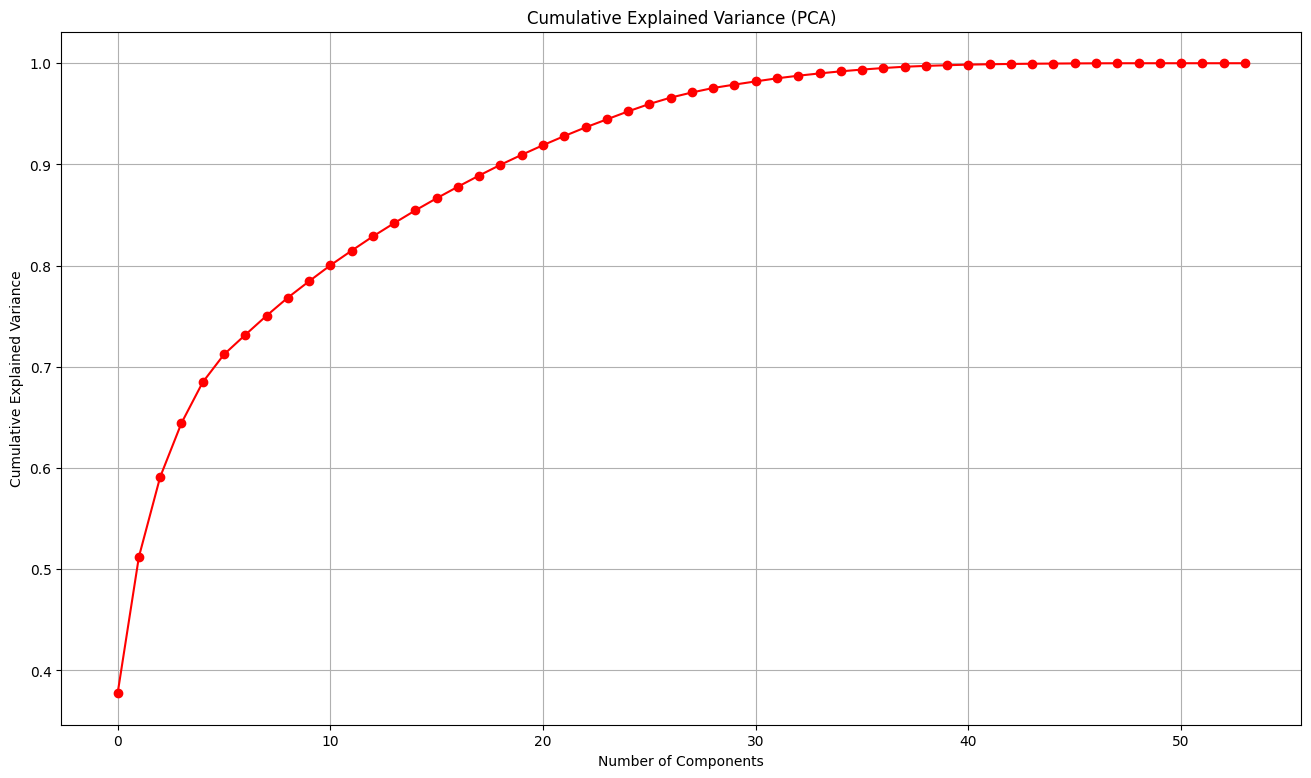

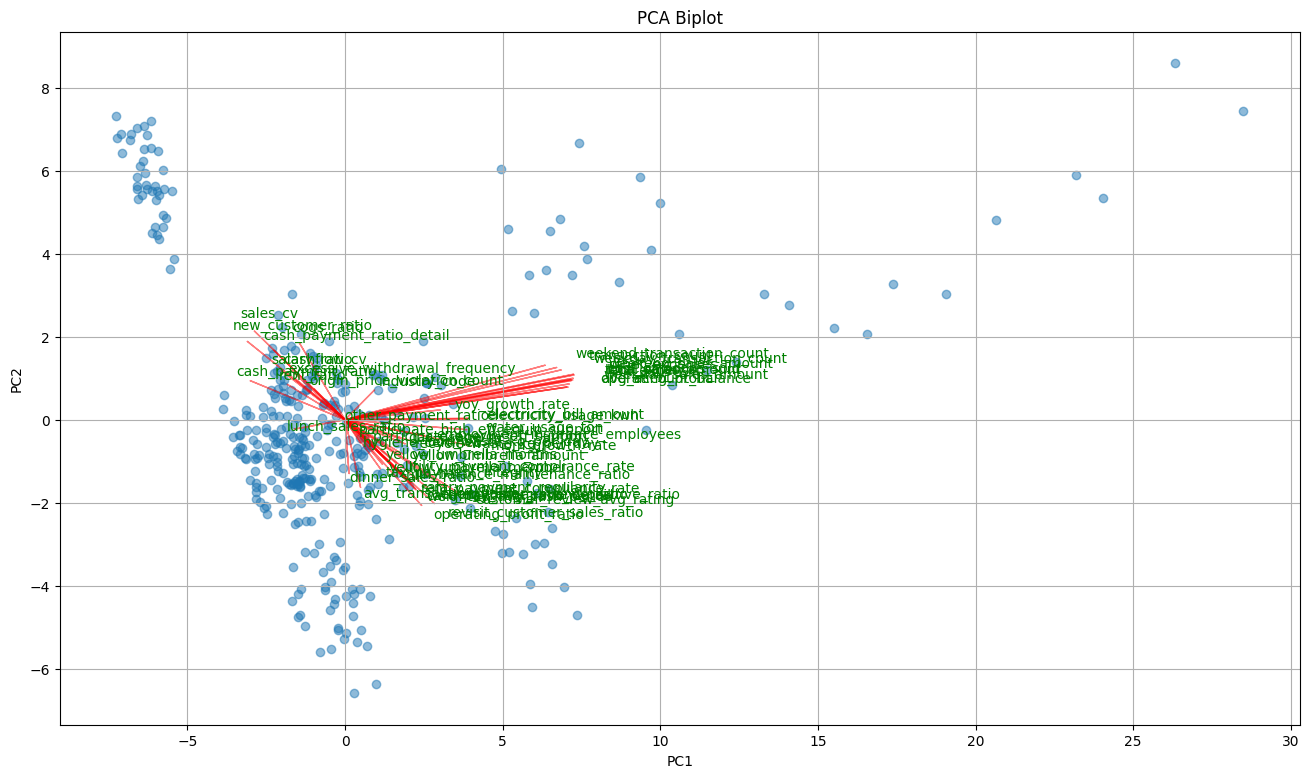

In [163]:
# pca_X = standardized_X.copy() # 원본 코드
pca_X = X_validation_filtered.copy() # 수정된 코드

# PCA 모델 생성 및 학습
pca = PCA()
pca.fit(pca_X)

# 주성분 결과 출력
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Components (Loadings):\n", pd.DataFrame(pca.components_, columns=pca_X.columns))

# Scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', color='red')
plt.title("Cumulative Explained Variance (PCA)")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

# Biplot 함수 (함수 정의는 수정할 필요 없음)
def biplot(score, coeff, labels=None):
    xs = score[:,0]
    ys = score[:,1]
    plt.scatter(xs, ys, alpha=0.5)
    for i in range(coeff.shape[0]):
        plt.arrow(0, 0, coeff[i,0]*max(xs), coeff[i,1]*max(ys),
                  color='r', alpha=0.5)
        if labels is None:
            plt.text(coeff[i,0]*max(xs)*1.15, coeff[i,1]*max(ys)*1.15, "Var"+str(i+1), color='g')
        else:
            plt.text(coeff[i,0]*max(xs)*1.15, coeff[i,1]*max(ys)*1.15, labels[i], color='g')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA Biplot")
    plt.grid(True)
    plt.show()

# Biplot 호출 시에도 수정된 pca_X와 해당 열 이름을 사용
biplot(pca.transform(pca_X), pca.components_.T, labels=pca_X.columns)

### 점수 계산

## 최종 점수 산출 과정 ##
 - Factor1: 소속 변수 12개, 가중치(설명분산)=0.2228 적용 완료
 - Factor2: 소속 변수 25개, 가중치(설명분산)=0.1811 적용 완료
 - Factor3: 소속 변수 6개, 가중치(설명분산)=0.0846 적용 완료
 - Factor4: 소속 변수 5개, 가중치(설명분산)=0.0802 적용 완료
 - Factor5: 소속 변수 6개, 가중치(설명분산)=0.0460 적용 완료

## 최종 산출 점수 (상위 5개) ##
   final_score  Factor1_Score  Factor2_Score  Factor3_Score  Factor4_Score  \
0    -1.709467      -4.544106      -5.536337       2.317347       2.059530   
1    -1.227705      -4.314842      -2.239359       1.523037       1.075696   
2    -2.086451      -4.180615      -6.081385       0.458909      -0.455129   
3    -1.373151      -4.072428      -2.173775       0.723356      -0.735274   
4    -0.536625      -3.993201       1.914651       0.566772      -1.306535   

   Factor5_Score  
0      -1.203410  
1      -1.648078  
2      -1.213435  
3      -1.615608  
4       1.374234  


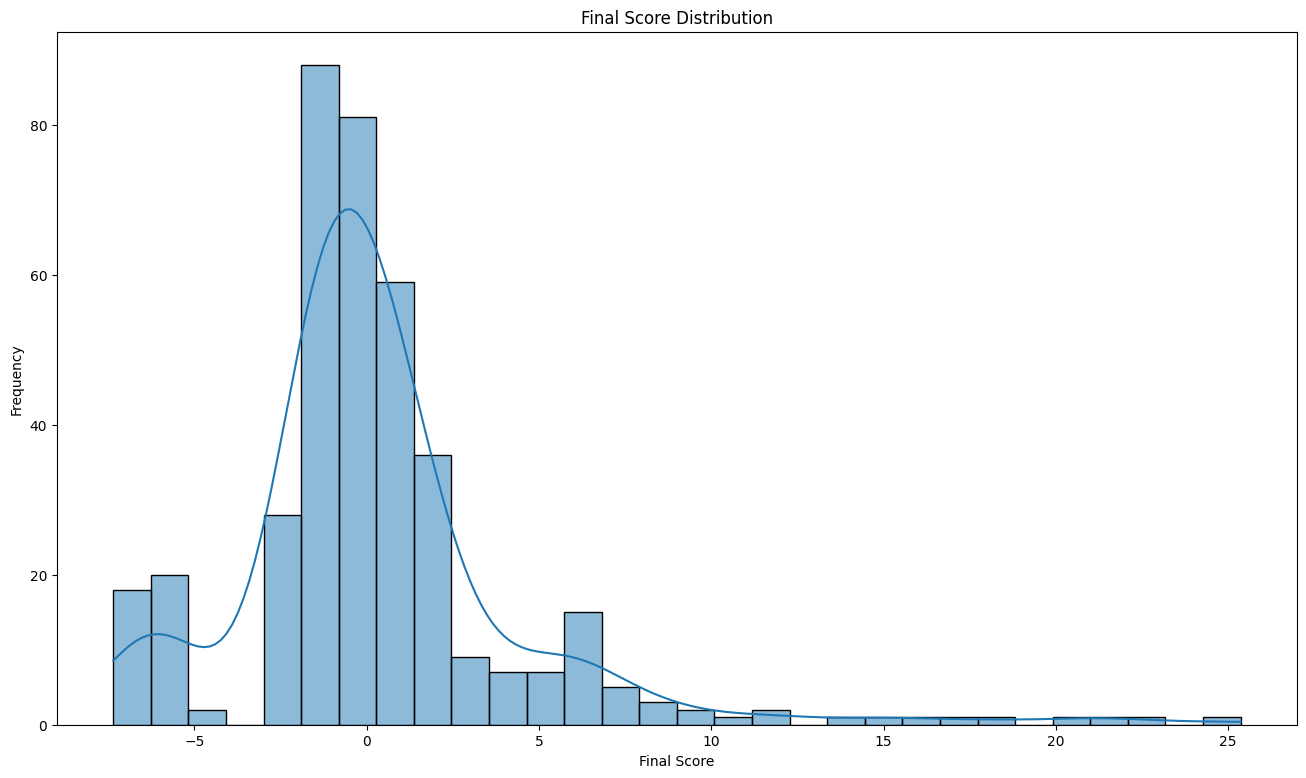

In [164]:
# 1. Proportional Var를 가중치로 사용
factor_weights = v

# 2. 변수별 소속 요인 결정: 가장 높은 적재량 값을 갖는 요인에 할당
# 결과 예시: {'매출액': 0, '고객수': 0, '전기요금': 1, ...}
variable_factor_mapping = loadings.abs().idxmax(axis=1)

# 3. 요인별 점수 및 최종 가중합 계산을 위한 데이터프레임 준비
# 원본 데이터의 인덱스를 그대로 사용
final_scores_df = pd.DataFrame(index=X_validation_filtered.index)
final_scores_df['final_score'] = 0  # 최종 점수를 저장할 컬럼 초기화

print("## 최종 점수 산출 과정 ##")
# 각 요인(Factor)별로 루프를 실행
for i in range(fa.n_factors):
    factor_name = f'Factor{i+1}'
    
    # 현재 요인(i)에 속하는 변수들만 선택
    variables_in_factor = variable_factor_mapping[variable_factor_mapping == i].index
    
    # 요인별 점수를 계산할 컬럼 초기화 (0으로 채워진 Series)
    factor_score_col = pd.Series(0, index=X_validation_filtered.index)
    
    # 해당 요인에 속한 변수들로 요인 점수 계산
    for var in variables_in_factor:
        # (변수의 표준화된 값 * 해당 변수의 요인 적재량)을 더해나감
        factor_score_col += X_validation_filtered[var] * loadings.loc[var, i]
    
    # 계산된 요인별 점수를 결과 데이터프레임에 추가
    final_scores_df[f'{factor_name}_Score'] = factor_score_col
    
    # 최종 점수에 (요인별 점수 * 요인별 가중치)를 더함
    final_scores_df['final_score'] += factor_score_col * factor_weights[i]
    print(f" - {factor_name}: 소속 변수 {len(variables_in_factor)}개, 가중치(설명분산)={factor_weights[i]:.4f} 적용 완료")

# 4. 결과 확인 (상위 5개 행)
print("\n## 최종 산출 점수 (상위 5개) ##")
print(final_scores_df.head())


# 5. 최종 점수 분포 시각화
sns.histplot(final_scores_df['final_score'], kde=True, bins=30)
plt.title('Final Score Distribution')
plt.xlabel('Final Score')
plt.ylabel('Frequency')
plt.show()

## 표준편차 기반 신용 점수 (Higher is Better) ##
   final_score  credit_score_std
0    -1.709467               203
1    -1.227705               221
2    -2.086451               188
3    -1.373151               215
4    -0.536625               248


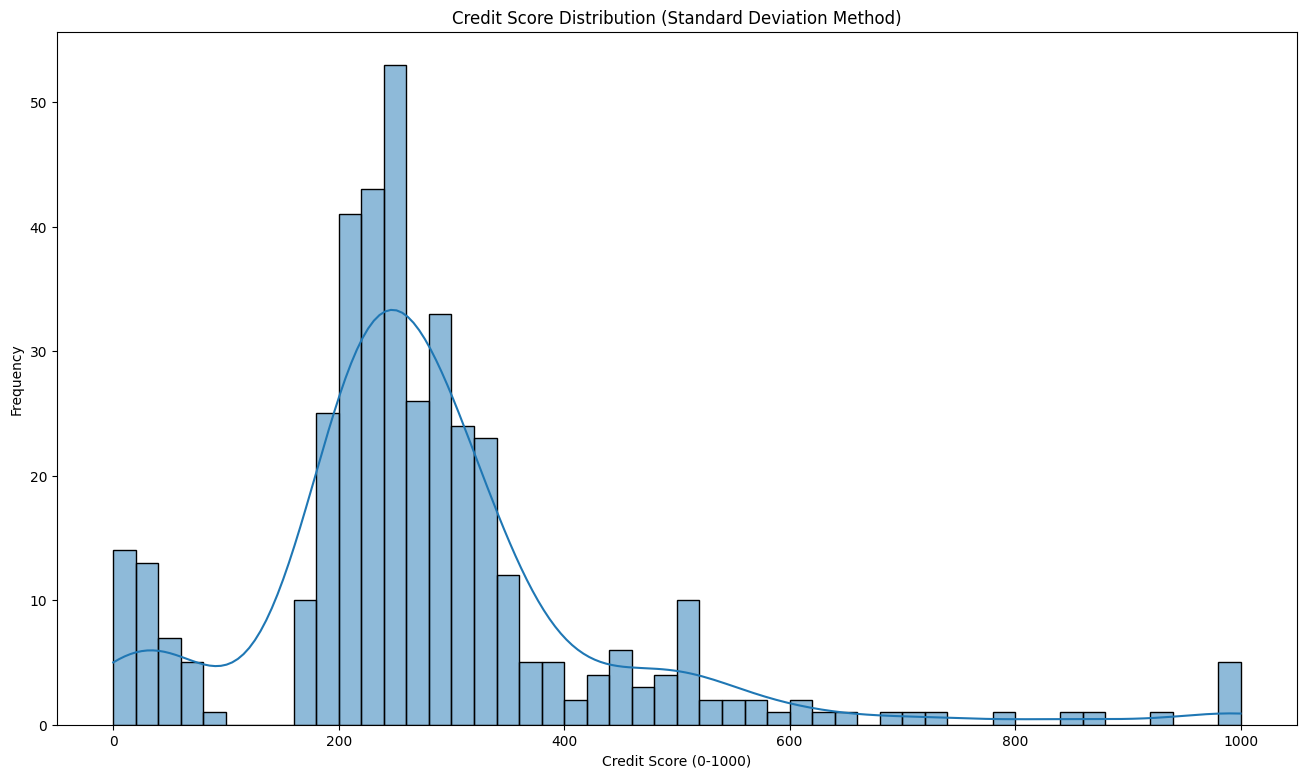

In [165]:
# 1. 이상치 영향을 줄이기 위해 하위 1%와 상위 99% 값을 경계로 설정
lower_bound = final_scores_df['final_score'].quantile(0.01)
upper_bound = final_scores_df['final_score'].quantile(0.99)

# 2. 경계를 벗어나는 값들을 경계값으로 고정 (Clipping)
clipped_score = final_scores_df['final_score'].clip(lower_bound, upper_bound)

# 3. 정리된 점수 범위를 0~1 사이로 스케일링 후 1000을 곱함
# 'Higher is Better' 로직이므로 이대로 사용합니다.
final_scores_df['credit_score_std'] = minmax_scale(clipped_score) * 1000

# 4. 최종 점수를 정수형으로 변환
final_scores_df['credit_score_std'] = final_scores_df['credit_score_std'].astype(int)

# 5. 결과 확인
print("## 표준편차 기반 신용 점수 (Higher is Better) ##")
print(final_scores_df[['final_score', 'credit_score_std']].head())

# 6. 변환된 점수 분포 시각화
sns.histplot(final_scores_df['credit_score_std'], bins=50, kde=True)
plt.title("Credit Score Distribution (Standard Deviation Method)")
plt.xlabel("Credit Score (0-1000)")
plt.ylabel("Frequency")
plt.show()

### 신규 데이터에 대한 점수 산출

In [166]:
import joblib

# 저장할 모든 자산을 하나의 딕셔너리에 담기
artifacts = {
    # [중요] Scaler는 필터링 전의 넓은 범위의 변수들을 학습했음
    "scaler_columns": validation_cols,  # Scaler가 학습한 컬럼 목록
    "scaler": scaler,                  # 학습된 Scaler 객체
    
    # 필터링 객체들
    "selector": selector,              # 학습된 VarianceThreshold 객체
    "to_drop_corr": to_drop,           # 제거할 상관관계 높은 변수 목록
    
    # [중요] FactorAnalyzer는 모든 필터링이 끝난 후의 변수들을 학습했음
    "fa_columns": X_validation_filtered.columns, # FactorAnalyzer가 학습한 최종 컬럼 목록
    "factor_analyzer": fa,                       # 학습된 FactorAnalyzer 객체
    
    # 점수 계산에 필요한 나머지 자산들
    "loadings": loadings,
    "variable_factor_mapping": variable_factor_mapping,
    "factor_weights": factor_weights,
    "score_lower_bound": lower_bound,
    "score_upper_bound": upper_bound,
}

# 파일로 저장
joblib.dump(artifacts, 'credit_scoring_artifacts.pkl')

['credit_scoring_artifacts.pkl']

In [167]:
# 테스트 데이터
data = {
    'store_id': [116, 111, 101, 126], 'owner_id': [1116, 1111, 1101, 1126], 'business_registration_no': ['116-XX-XXXXX', '111-XX-XXXXX', '101-XX-XXXXX', '126-XX-XXXXX'], 'industry_code': ['56111', '56114', '56220', '56113'], 'open_date': ['2015-03-10', '2010-05-20', '2024-09-01', '2021-07-18'], 'summary_year_month': ['2025-08', '2025-08', '2025-08', '2025-08'], 'total_sales_amount': [38000000.0, 11000000.0, 15000000.0, 21000000.0], 'weekday_sales_amount': [24700000.0, 8250000.0, 8250000.0, 14700000.0], 'weekend_sales_amount': [13300000.0, 2750000.0, 6750000.0, 6300000.0], 'lunch_sales_ratio': [35.0, 42.0, 15.0, 28.0], 'dinner_sales_ratio': [45.0, 30.0, 25.0, 40.0], 'transaction_count': [1520, 733, 2142, 1050], 'weekday_transaction_count': [988, 550, 1178, 735], 'weekend_transaction_count': [532, 183, 964, 315], 'mom_growth_rate': [0.5, -8.5, 12.5, -1.5], 'yoy_growth_rate': [4.5, -25.0, 150.0, -5.0], 'sales_cv': [0.045, 0.32, 0.18, 0.11], 'avg_transaction_value': [25000.0, 15000.0, 7000.0, 20000.0], 'revisit_customer_sales_ratio': [75.0, 25.0, 30.0, 55.0], 'new_customer_ratio': [15.0, 65.0, 70.0, 40.0], 'electricity_usage_kwh': [2200.0, 1200.0, 1800.0, 1900.0], 'electricity_bill_amount': [250000.0, 150000.0, 210000.0, 220000.0], 'gas_usage_m3': [760.0, 460.0, 180.0, 670.0], 'water_usage_ton': [35.0, 18.0, 22.0, 28.0], 'energy_eff_appliance_ratio': [85.0, 30.0, 65.0, 55.0], 'participate_energy_eff_support': [1, 0, 0, 0], 'food_waste_kg_per_day': [15.0, 12.0, 4.0, 10.0], 'recycle_waste_kg_per_day': [12.0, 8.0, 8.0, 9.0], 'yellow_umbrella_member': [1, 0, 0, 1], 'yellow_umbrella_months': [120, 0, 0, 36], 'yellow_umbrella_amount': [500000.0, 0.0, 0.0, 200000.0], 'employment_insurance_employees': [4, 1, 2, 3], 'customer_review_avg_rating': [4.6, 3.2, 4.1, 3.9], 'customer_review_positive_ratio': [92.0, 65.0, 82.0, 78.0], 'hygiene_certified': [1, 0, 0, 0], 'origin_price_violation_count': [0, 2, 0, 0], 'operating_profit': [9500000.0, -1100000.0, 1500000.0, 3150000.0], 'cost_of_goods_sold': [15200000.0, 5720000.0, 7500000.0, 9450000.0], 'total_salary': [6840000.0, 2640000.0, 2250000.0, 3780000.0], 'rent_expense': [3420000.0, 1760000.0, 1800000.0, 2100000.0], 'other_expenses': [3040000.0, 1980000.0, 1950000.0, 2520000.0], 'operating_profit_ratio': [25.0, -10.0, 10.0, 15.0], 'cogs_ratio': [40.0, 52.0, 50.0, 45.0], 'salary_ratio': [18.0, 24.0, 15.0, 18.0], 'rent_ratio': [9.0, 16.0, 12.0, 10.0], 'cashflow_cv': [0.15, 1.85, 0.95, 0.55], 'avg_account_balance': [35000000.0, 2200000.0, 6000000.0, 15000000.0], 'min_balance_maintenance_ratio': [90.0, 25.0, 40.0, 65.0], 'excessive_withdrawal_frequency': [0.5, 8.0, 4.0, 2.0], 'rent_payment_compliance_rate': [100.0, 75.0, 95.0, 98.0], 'utility_payment_compliance_rate': [100.0, 80.0, 90.0, 95.0], 'salary_payment_regularity': [100.0, 85.0, 98.0, 99.0], 'tax_payment_integrity': [100.0, 70.0, 90.0, 95.0], 'cash_payment_ratio': [15.0, 45.0, 25.0, 30.0], 'card_payment_ratio': [85.0, 55.0, 75.0, 70.0], 'participate_high_eff_equip_support': [1, 0, 0, 0], 'cash_payment_ratio_detail': [14.0, 42.0, 23.0, 28.0], 'card_payment_ratio_detail': [83.0, 54.0, 74.0, 69.0], 'other_payment_ratio': [3.0, 4.0, 3.0, 3.0], 'weighted_avg_cash_period': [2.1, 1.5, 2.0, 1.8], 'operating_expenses': [28500000.0, 12100000.0, 13500000.0, 17850000.0], 'operating_expense_ratio': [75.0, 110.0, 90.0, 85.0], 'weekday_avg_transaction_value': [24000.0, 14000.0, 6500.0, 19000.0], 'weekend_avg_transaction_value': [26000.0, 16000.0, 7500.0, 21000.0]
}
new_data_df = pd.DataFrame(data)

In [168]:
def get_credit_score(new_data_df):
    """
    신규 데이터(DataFrame)를 입력받아 최종 신용 점수를 계산하는 파이프라인 함수.
    
    [필수 조건]
    1. 이 함수와 같은 경로에 'credit_scoring_artifacts.pkl' 파일이 있어야 합니다.
    2. new_data_df는 학습에 사용된 초기 데이터와 동일한 컬럼명을 가지고 있어야 합니다.
    
    :param new_data_df: 신규 상점 데이터 (1개 또는 여러 개)
    :return: 최종 점수가 포함된 DataFrame
    """
    try:
        # 1. 저장된 모델 자산(artifacts) 불러오기
        artifacts = joblib.load('credit_scoring_artifacts.pkl')
    except FileNotFoundError:
        print("에러: 'credit_scoring_artifacts.pkl' 파일을 찾을 수 없습니다.")
        print("학습 코드를 먼저 실행하여 모델 자산 파일을 생성해야 합니다.")
        return None

    # --- 2. 전처리 단계 ---
    # 저장된 객체 및 컬럼 목록 추출
    scaler = artifacts['scaler']
    scaler_cols = artifacts['scaler_columns']
    selector = artifacts.get('selector') # selector가 없을 수도 있으므로 .get() 사용
    to_drop_corr = artifacts['to_drop_corr']
    fa_cols = artifacts['fa_columns']

    # 2-1. Scaler가 학습했던 컬럼들만 신규 데이터에서 선택
    # 만약 신규 데이터에 컬럼이 부족하면 0으로 채움
    processed_df = pd.DataFrame(columns=scaler_cols, index=new_data_df.index)
    common_cols = [col for col in scaler_cols if col in new_data_df.columns]
    processed_df[common_cols] = new_data_df[common_cols]
    processed_df.fillna(0, inplace=True)

    # 2-2. 저장된 Scaler로 표준화 수행 (.transform)
    scaled_data = scaler.transform(processed_df)
    scaled_df = pd.DataFrame(scaled_data, columns=scaler_cols, index=processed_df.index)

    # 2-3. 저장된 VarianceThreshold로 변수 제거 (.transform)
    if selector:
        var_filtered_data = selector.transform(scaled_df)
        filtered_df = pd.DataFrame(var_filtered_data, 
                                   columns=scaled_df.columns[selector.get_support()],
                                   index=scaled_df.index)
    else:
        filtered_df = scaled_df

    # 2-4. 저장된 상관관계 변수 목록으로 변수 제거 (.drop)
    filtered_df = filtered_df.drop(columns=to_drop_corr, errors='ignore')

    # 2-5. 최종적으로 FactorAnalyzer가 학습했던 변수/순서와 동일하게 맞춤
    final_processed_data = filtered_df[fa_cols]
    
    # --- 3. 최종 점수 계산 단계 ---
    final_scores_df = pd.DataFrame(index=final_processed_data.index)
    final_scores_df['final_score'] = 0
    
    fa_model = artifacts['factor_analyzer']
    loadings = artifacts['loadings']
    mapping = artifacts['variable_factor_mapping']
    weights = artifacts['factor_weights']

    for i in range(fa_model.n_factors):
        variables_in_factor = mapping[mapping == i].index
        factor_score_col = pd.Series(0.0, index=final_processed_data.index)
        
        for var in variables_in_factor:
            if var in final_processed_data.columns:
                factor_score_col += final_processed_data[var] * loadings.loc[var, i]
        final_scores_df['final_score'] += factor_score_col * weights[i]
        
    # --- 4. 0-1000점 척도 변환 단계 ---
    lower_b, upper_b = artifacts['score_lower_bound'], artifacts['score_upper_bound']
    clipped_score = final_scores_df['final_score'].clip(lower_b, upper_b)
    final_scores_df['credit_score'] = ((clipped_score - lower_b) / (upper_b - lower_b)) * 1000
    final_scores_df['credit_score'] = final_scores_df['credit_score'].fillna(0).astype(int)
    
    # 원본 데이터와 최종 점수 합쳐서 반환
    return pd.concat([new_data_df, final_scores_df], axis=1)